In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

w_df=pd.read_csv('weather.csv')
w_df

,Date,Minimum.temperature...C.,Maximum.temperature...C.,Evaporation..mm.,Sunshine..hours.,Direction.of.maximum.wind.gust,Speed.of.maximum.wind.gust..km.h.,Time.of.maximum.wind.gust,X9am.Temperature...C.,X9am.relative.humidity....,...,X3pm.Temperature...C.,X3pm.relative.humidity....,X3pm.cloud.amount..oktas.,X3pm.wind.direction,X3pm.wind.speed..km.h.,X3pm.MSL.pressure..hPa.,Rainfall..mm.,rain.today,Rainfall..mm.tmr,rain.tomorrow
0,01-07-2020,13.2,29.0,NaN,NaN,ENE,31,09:45,21.3,39,...,28.3,25,0,NE,13,1014.1,0.0,No,0.0,No
1,02-07-2020,8.6,29.8,NaN,NaN,NE,30,13:19,18.2,43,...,29.4,26,0,ESE,15,1015.9,0.0,No,0.0,No
2,03-07-2020,14.0,27.6,NaN,NaN,SSE,37,14:11,19.6,40,...,27.0,28,0,S,28,1020.9,0.0,No,0.0,No
3,04-07-2020,12.7,22.9,NaN,NaN,SE,46,09:19,14.9,32,...,22.2,15,0,SE,19,1021.7,0.0,No,0.0,No
4,05-07-2020,13.3,21.5,NaN,NaN,SSE,37,02:57,14.1,39,...,20.6,24,0,SE,19,1021.1,0.0,No,0.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,27-08-2021,3.8,28.9,NaN,NaN,SE,31,10:01,17.8,18,...,27.5,9,0,W,17,1014.0,0.0,No,0.0,No
423,28-08-2021,4.1,31.2,NaN,NaN,WSW,26,12:00,20.0,18,...,29.8,8,0,S,7,1012.6,0.0,No,0.0,No
424,29-08-2021,5.7,33.2,NaN,NaN,E,35,11:05,20.8,14,...,32.4,8,0,SE,17,1012.1,0.0,No,0.0,No
425,30-08-2021,8.1,34.0,NaN,NaN,SE,33,11:14,24.6,15,...,32.0,8,0,SW,13,1012.6,0.0,No,0.0,No


In [3]:
w_df.shape

(427, 24)

In [418]:
w_df.rename(columns={'rain.tomorrow':'rain_tomorrow'},inplace=True)

In [419]:
w_df['rain_tomorrow']

0      No
1      No
2      No
3      No
4      No
       ..
422    No
423    No
424    No
425    No
426    No
Name: rain_tomorrow, Length: 427, dtype: object

In [420]:
# convert output (Y,N) to (1,0)

rain_tomorrow={'Yes':1,'No':0}

w_df.rain_tomorrow=[rain_tomorrow[item] for item in w_df.rain_tomorrow]

# Drop columns

In [421]:
# remove na>50

na_df=pd.DataFrame({'col_name':w_df.columns,'na_per':w_df.isnull().sum()/w_df.shape[0]*100})

na_grt50=list(na_df[na_df['na_per']>50]['col_name'])

na_grt50

['Evaporation..mm.', 'Sunshine..hours.']

In [422]:
# non-sense columns

non_sense=[col for col in w_df.columns if w_df[col].nunique==1 or w_df[col].nunique==w_df[col].shape[0]]

non_sense

[]

In [423]:
col_to_drop=na_grt50+non_sense
col_to_drop

['Evaporation..mm.', 'Sunshine..hours.']

In [424]:
# drop columns now

w_df.drop(columns=col_to_drop,inplace=True)

# CHI-SQUARE

In [425]:
from scipy.stats import chi2_contingency

con_cols=[col for col in w_df.columns if w_df[col].dtype=='int64' or w_df[col].dtype=='float64']

cat_cols=[col for col in w_df.columns if w_df[col].dtype=='object']

sig_val=0.05
chi2_corr_cols=[]
chi2_nocorr_cols=[]

for col in cat_cols:
    contingency_table=pd.crosstab(w_df[col],w_df['rain_tomorrow'])
    p_value=chi2_contingency(contingency_table)[1]
    if p_value<sig_val:
        chi2_corr_cols.append(col)
    else:
        chi2_nocorr_cols.append(col)
    
print(chi2_corr_cols)
print(chi2_nocorr_cols)


['Direction.of.maximum.wind.gust', 'X9am.wind.direction', 'X3pm.wind.direction', 'rain.today']
['Date', 'Time.of.maximum.wind.gust']


# ANOVA

In [426]:
from scipy.stats import f_oneway

sig_val=0.05
anova_corr_cols=[]
anova_non_corr_cols=[]

con_cols=[col for col in w_df.columns if w_df[col].dtype=='int64' or w_df[col].dtype=='float64']

for col in con_cols:
    y_list=list(w_df[w_df['rain_tomorrow']==1][col])
    n_list=list(w_df[w_df['rain_tomorrow']==0][col])
    
    p_value=f_oneway(y_list,n_list)[1]
    
    if p_value<sig_val:
        anova_corr_cols.append(col)
    else:
        anova_non_corr_cols.append(col)
        

print(anova_corr_cols)
print(anova_non_corr_cols)

['Minimum.temperature...C.', 'Maximum.temperature...C.', 'Speed.of.maximum.wind.gust..km.h.', 'X9am.Temperature...C.', 'X9am.relative.humidity....', 'X9am.cloud.amount..oktas.', 'X9am.MSL.pressure..hPa.', 'X3pm.relative.humidity....', 'X3pm.cloud.amount..oktas.', 'X3pm.MSL.pressure..hPa.', 'rain_tomorrow']
['X9am.wind.speed..km.h.', 'X3pm.Temperature...C.', 'X3pm.wind.speed..km.h.', 'Rainfall..mm.', 'Rainfall..mm.tmr']


In [427]:
all_non_corr_cols=anova_non_corr_cols+chi2_nocorr_cols
y=w_df['rain_tomorrow']
all_non_corr_cols.append('rain_tomorrow')

w_df.drop(columns=all_non_corr_cols,inplace=True)


# Train-Test Split

In [428]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(w_df,y,train_size=0.8,random_state=42)

In [429]:
# fill NA values

con_cols=[col for col in w_df.columns if w_df[col].dtype=='int64' or w_df[col].dtype=='float64']
cat_cols=[col for col in w_df.columns if w_df[col].dtype=='object']

for col in con_cols:
    x_train[col].fillna(x_train[col].mean(),inplace=True)
    x_test[col].fillna(x_train[col].mean(),inplace=True)
    
for col in cat_cols:
    x_train[col].fillna(x_train[col].mode()[0],inplace=True)
    x_test[col].fillna(x_train[col].mode()[0],inplace=True)


# scaling

In [430]:
from sklearn.preprocessing import StandardScaler
import numpy as np

std_scalar=StandardScaler()

for col in con_cols:
    x_train[col]=std_scalar.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col]=std_scalar.transform(np.array(x_test[col]).reshape(-1,1))

In [431]:
oe_train=pd.get_dummies(x_train[cat_cols])

oe_test=pd.get_dummies(x_test[cat_cols])

In [432]:
print(oe_train.shape)
print(oe_test.shape)

(341, 50)
(86, 46)


In [433]:
oe_train_final,oe_test_final=oe_train.align(oe_test,join='inner',axis=1)

In [434]:
print(oe_train_final.shape)
print(oe_test_final.shape)

(341, 46)
(86, 46)


In [435]:
x_train_final=pd.concat([x_train[con_cols],oe_train_final],axis=1)
x_test_final=pd.concat([x_test[con_cols],oe_test_final],axis=1)

# Logistic regression

In [436]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression()

logreg.fit(x_train_final,y_train)

LogisticRegression()

In [437]:
test_pred=logreg.predict(x_test_final)
train_pred=logreg.predict(x_train_final)

In [438]:
probabs=logreg.predict_proba(x_test_final)

pos_probabs=probabs[::,1]

In [439]:
# auc-roc curve
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_test,pos_probabs)

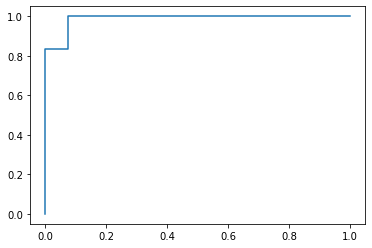

In [440]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr)

In [441]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test,test_pred)

0.9166666666666667

In [442]:
# confusion matrix

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train,train_pred))
print(confusion_matrix(y_test,test_pred))

[[318   1]
 [ 13   9]]
[[80  0]
 [ 1  5]]


In [443]:
from sklearn.metrics import precision_score

print(precision_score(y_train,train_pred))
print(precision_score(y_test,test_pred))

0.9
1.0


In [444]:
from sklearn.metrics import recall_score

recall_score(y_test,test_pred)

0.8333333333333334

In [445]:
from sklearn.metrics import f1_score 

f1_score(y_test,test_pred)

0.9090909090909091

In [446]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,test_pred) # Test accuracy

0.9883720930232558

In [447]:
accuracy_score(y_train,train_pred) # Train accuracy

0.9589442815249267